In [74]:
%matplotlib notebook
#Importando bibliotecas necessárias
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot
import statsmodels.api as sm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

# split a dataset into train and test sets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split



In [2]:
#Carregando o dataset principal (target) sobre a produção de carne
target_carne_produzida = pd.read_csv('meat-production-tonnes.csv')

#Renomeando e criando algumas variáveis do dataset para deixar mais organizado e separar apenas os dados de 2010
pais_carne_produzida = target_carne_produzida['Entity']    
producao_2010 = target_carne_produzida['Year'] == 2010
target_carne_produzida = target_carne_produzida.loc[producao_2010, :]
target_carne_produzida = target_carne_produzida.rename(columns={'Entity' : 'Country'})
target_carne_produzida = target_carne_produzida.rename(columns={'Livestock Primary - Meat, Total - 1765 - Production - 5510 - tonnes (tonnes)' : 'Meat Tonnes'})

In [3]:
#Carregando um dataset de feature sobre o consumo de carne
feature_consumo_per_capita = pd.read_csv('per-capita-meat-consumption-by-type-kilograms-per-year.csv')

#Renomeando e criando algumas variáveis do dataset para deixar mais organizado e separar apenas os dados de 2010
producao_2010 = feature_consumo_per_capita['Year'] == 2010
consumo_2010_per_cpt = feature_consumo_per_capita.loc[producao_2010, :]
consumo_2010_per_cpt = consumo_2010_per_cpt.loc[:, ['Entity', 'Year', 'Beef and bufallo (kilograms per year)']]
consumo_2010_per_cpt = consumo_2010_per_cpt.rename(columns={'Entity' : 'Country'})
pais_consumo_2010_per_cpt = consumo_2010_per_cpt['Country']

In [4]:
#Carregando um dataset de features importantes (IDH, Expect. de vida, etc...)
feature_IDH = pd.read_csv('HDI.csv')

#Renomeando e criando algumas variáveis do dataset para deixar mais organizado
IDH_dados_importantes = feature_IDH.loc[:,['Country', 'HDI', 'Life expectancy', 'Mean years of schooling', 'Coefficient of human inequality']]
pais_IDH = IDH_dados_importantes['Country']

In [5]:
#Carregando um dataset de feature sobre o desemprego 
feature_desemprego_pais = pd.read_csv('API_ILO_country_YU.csv')

#Renomeando e criando algumas variáveis do dataset para deixar mais organizado e separar apenas os dados de 2010
desemprego_2010 = feature_desemprego_pais.loc[:,['Country Name', '2010']]
desemprego_2010 = desemprego_2010.rename(columns={'Country Name' : 'Country'})
desemprego_2010 = desemprego_2010.rename(columns={'2010' : 'Desemprego em 2010'})

In [6]:
#Carregando um dataset de feature sobre o PIB
feature_pib = pd.read_csv('GDP.csv')

#Renomeando e criando algumas variáveis do dataset para deixar mais organizado e separar apenas os dados de 2010
pib_2010 = feature_pib.loc[:,['Country ', '2010']]
pib_2010 = pib_2010.rename(columns={'2010' : 'PIB em 2010'})

In [7]:
feature_dados_commodity = pd.read_csv('commodity_trade_statistics_data.csv') 
ano_2010 = feature_dados_commodity['year'] == 2010
commodity_2010 = feature_dados_commodity.loc[ano_2010, :]
commodity_2010 = commodity_2010.loc[:, ['country_or_area', 'year', 'commodity', 'flow', 'trade_usd', 'weight_kg', 'category']]

FileNotFoundError: [Errno 2] No such file or directory: 'commodity_trade_statistics_data.csv'

## Agora, iremos juntar todos os datasets anteriores em um único para fazermos as regressões e análises

In [8]:
#Juntando todos os datasets em um único, tendo como base (index principal) o país
tabela_1 = target_carne_produzida.set_index('Country').join(consumo_2010_per_cpt.set_index('Country'), lsuffix='_carne', rsuffix='_consumo')
tabela_2 = tabela_1.join(IDH_dados_importantes.set_index('Country'), lsuffix='_carne', rsuffix='_consumo')
tabela_3 = tabela_2.join(desemprego_2010.set_index('Country'), lsuffix='_carne', rsuffix='_consumo' )
tabela_final = tabela_3.join(pib_2010.set_index('Country '), lsuffix='_carne', rsuffix='_consumo')

In [9]:
#Retirando os países que apresentarem 'NaN' e removendo algumas colunas para deixar mais organizado e melhor para ser analisado
tabela_final = tabela_final.dropna()
tabela_final = tabela_final.drop(columns=['Code', 'Year_consumo', 'Year_carne'])
tabela_final

,Meat Tonnes,Beef and bufallo (kilograms per year),HDI,Life expectancy,Mean years of schooling,Coefficient of human inequality,Desemprego em 2010,PIB em 2010
Country,,,,,,,,
Afghanistan,328160,4.70,0.479,60.7,3.6,30.4,20.600000,1637.377987
Albania,91440,21.38,0.764,78.0,9.6,13.4,25.799999,9628.025783
Angola,217027,6.67,0.533,52.7,5.0,36.6,10.800000,6230.297028
Argentina,4721922,54.65,0.827,76.5,9.9,15.2,19.500000,18524.856760
Armenia,69484,18.01,0.743,74.9,11.3,9.2,38.299999,6565.678660
...,...,...,...,...,...,...,...,...
United States,41952752,38.66,0.920,79.2,13.2,12.9,18.700001,48466.823380
Uruguay,652983,30.76,0.795,77.4,8.6,15.4,20.799999,16808.284880
Uzbekistan,818300,23.98,0.701,69.4,12.0,15.3,20.600000,5136.234068


In [10]:
#Renomeando todas as colunas para deixar em português e com algumas unidades utilizadas
tabela_final = tabela_final.rename(columns={'Beef and bufallo (kilograms per year)' : 'Carne consumida/capita (kg/ano)'})
tabela_final = tabela_final.rename(columns={'HDI' : 'IDH'})
tabela_final = tabela_final.rename(columns={'Meat Tonnes' : 'Carne produzida (toneladas/ano)'})
tabela_final = tabela_final.rename(columns={'Life expectancy' : 'Expectativa de vida (anos)'})
tabela_final = tabela_final.rename(columns={'Mean years of schooling' : 'Média de escolaridade (anos)'})
tabela_final = tabela_final.rename(columns={'Coefficient of human inequality' : 'Coeficiente de desigualdade humana'})
tabela_final = tabela_final.rename(columns={'Desemprego em 2010' : 'Taxa de desemprego (%)'})
tabela_final = tabela_final.rename(columns={'PIB em 2010' : 'PIB per capita (U$)'})

In [12]:
tabela_final.head(50)

,Carne produzida (toneladas/ano),Carne consumida/capita (kg/ano),IDH,Expectativa de vida (anos),Média de escolaridade (anos),Coeficiente de desigualdade humana,Taxa de desemprego (%),PIB per capita (U$)
Country,,,,,,,,
Afghanistan,328160,4.70,0.479,60.7,3.6,30.4,20.600000,1637.377987
Albania,91440,21.38,0.764,78.0,9.6,13.4,25.799999,9628.025783
Angola,217027,6.67,0.533,52.7,5.0,36.6,10.800000,6230.297028
Argentina,4721922,54.65,0.827,76.5,9.9,15.2,19.500000,18524.856760
Armenia,69484,18.01,0.743,74.9,11.3,9.2,38.299999,6565.678660
Australia,4047952,37.25,0.939,82.5,13.2,8.0,11.400000,39324.368950
Austria,920059,17.41,0.893,81.6,11.3,8.5,8.800000,42006.046880
Azerbaijan,251911,12.35,0.759,70.9,11.2,13.0,14.600000,15884.044790
Bangladesh,607355,1.29,0.579,72.0,5.2,28.6,8.200000,2466.902949


In [27]:
sns.set_theme(color_codes=True)
fig_expect = sns.scatterplot(data=df, x='Expectativa de vida (anos)', y='Carne produzida (toneladas/ano)', hue='PIB per capita (U$)')
plt.show(fig_expect)

<IPython.core.display.Javascript object>

#### A partir do gráfico, pode-se notar que o PIB per capita dos países está diretamente relacionado com a expectativa de vida, tendo em vista que a medida que o eixo X (expectativa de vida) cresce, mais bolinhas escuras são observadas (quanto mais escura, maior o PIB per capita). Em relação à carne produzida, não se pode tirar muitas conclusões, apesar de que observa-se que à medida que a expectativa de vida cresce, mais pontos são observados em uma posição maior em relação ao eixo Y (carne produzida). Com isso, tira-se a conclusão de que eles podem até estar relacionados, porém essa relação acaba não sendo tão forte/visível. 

<IPython.core.display.Javascript object>


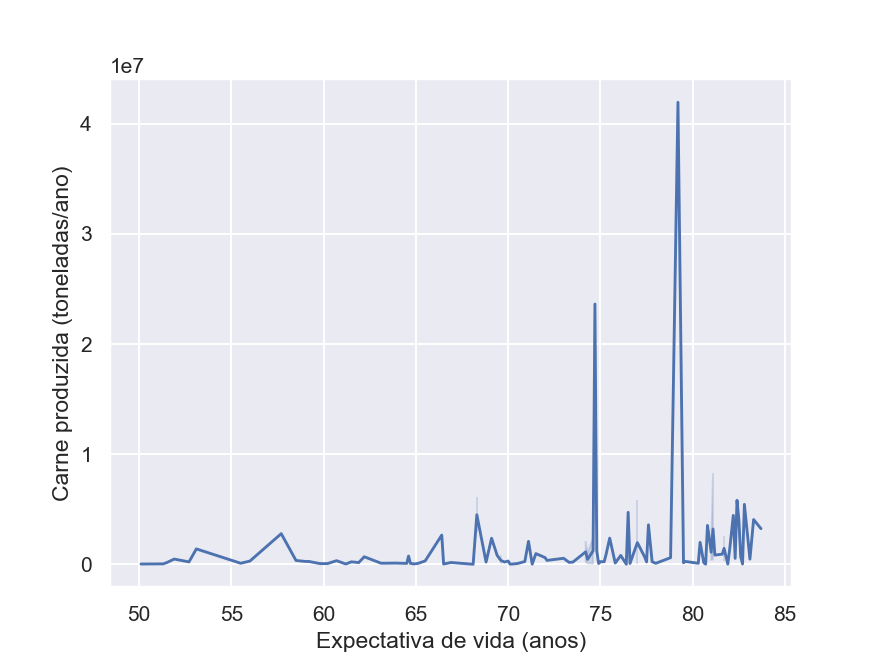

In [50]:
graf_linha_expec = sns.lineplot(data=df, x='Expectativa de vida (anos)', y='Carne produzida (toneladas/ano)')
plt.show(graf_linha_expec)

#### Conforeme há um aumento na expectativa de vida (eixo X cresce), valores maiores de carne produzida podem ser observados. Entretanto, esses valores não apresentam um alto grau de constância, tendo em vista que são identificados apenas alguns picos, porém muitos valores (no eixo X) em uma mesma faixa de carne produzida (no eixo Y).

<IPython.core.display.Javascript object>


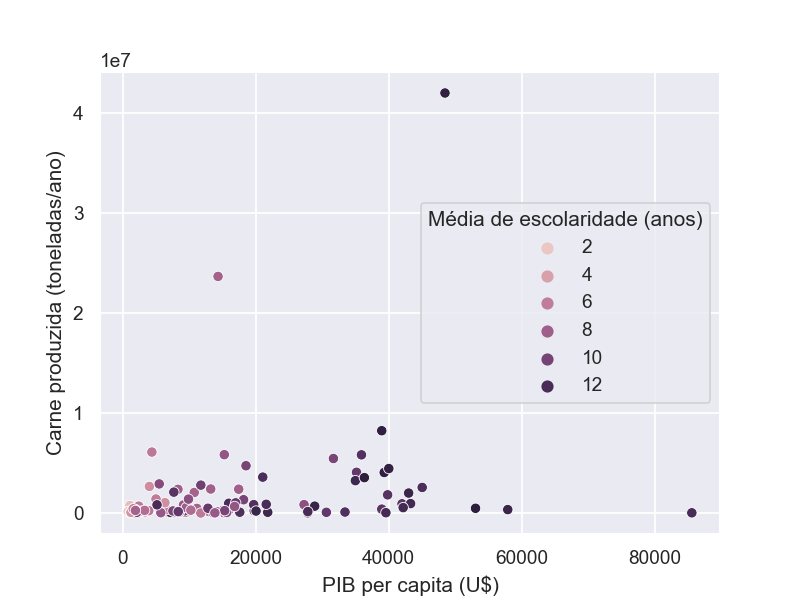

In [52]:
sns.set_theme(color_codes=True)
fig_pib = sns.scatterplot(data=df, x='PIB per capita (U$)', y='Carne produzida (toneladas/ano)', hue='Média de escolaridade (anos)')
plt.show(fig_pib)

#### Com base no gráfico obtido, nota-se um alto grau de relação entre a média de escolaridade e o PIB per capita, tendo em vista que à medida que o eixo X cresce (maior PIB), mais bolinhas escuras (maior escolaridade) são observadas. No entanto, não se pode observar um grau de relação muito grande entre essas duas variáveis e a carne produzida, tendo em vista que a maior parte dos valores estão na mesma faixa abaixo de 1 tonelada de carne produzida, independente do número do PIB do país.

<IPython.core.display.Javascript object>


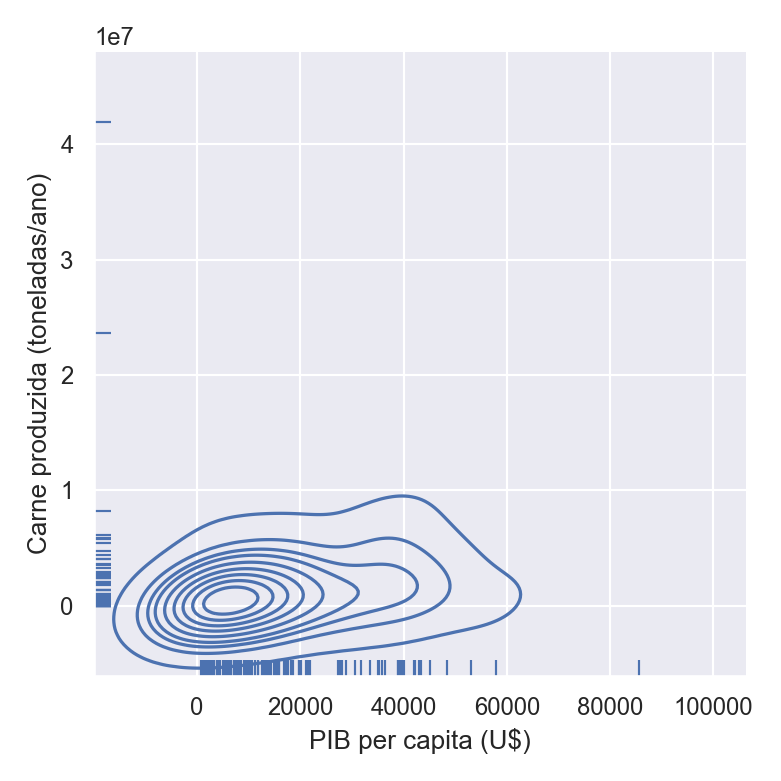

In [33]:
hist_pib = sns.displot(data=df, x='PIB per capita (U$)', y='Carne produzida (toneladas/ano)', kind='kde', rug='True')
plt.show(hist_pib)

#### Com o gráfico obtido, nota-se um pouco da desigualdade econômica entre os países analisados no projeto, tendo em vista que a maior parte dos países analisados possuem um PIB per capita menor que 40000 dólares. Apesar dessa desigualdade, nota-se que a maior parte desses países não apresentam uma grande diferença no que diz respeito à carne produzida, evidênciando que as duas variáveis não apresentam um alto grau de relação. 

<IPython.core.display.Javascript object>


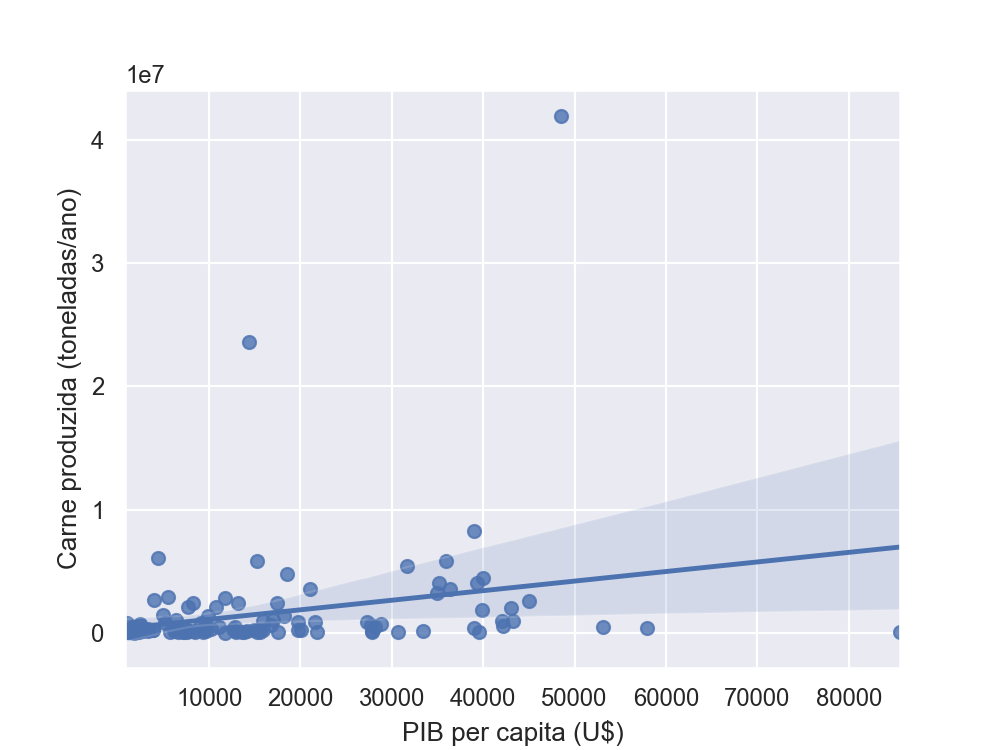

In [34]:
fig_reg_pib = sns.regplot(data=df, x='PIB per capita (U$)', y='Carne produzida (toneladas/ano)')
plt.show(fig_reg_pib)

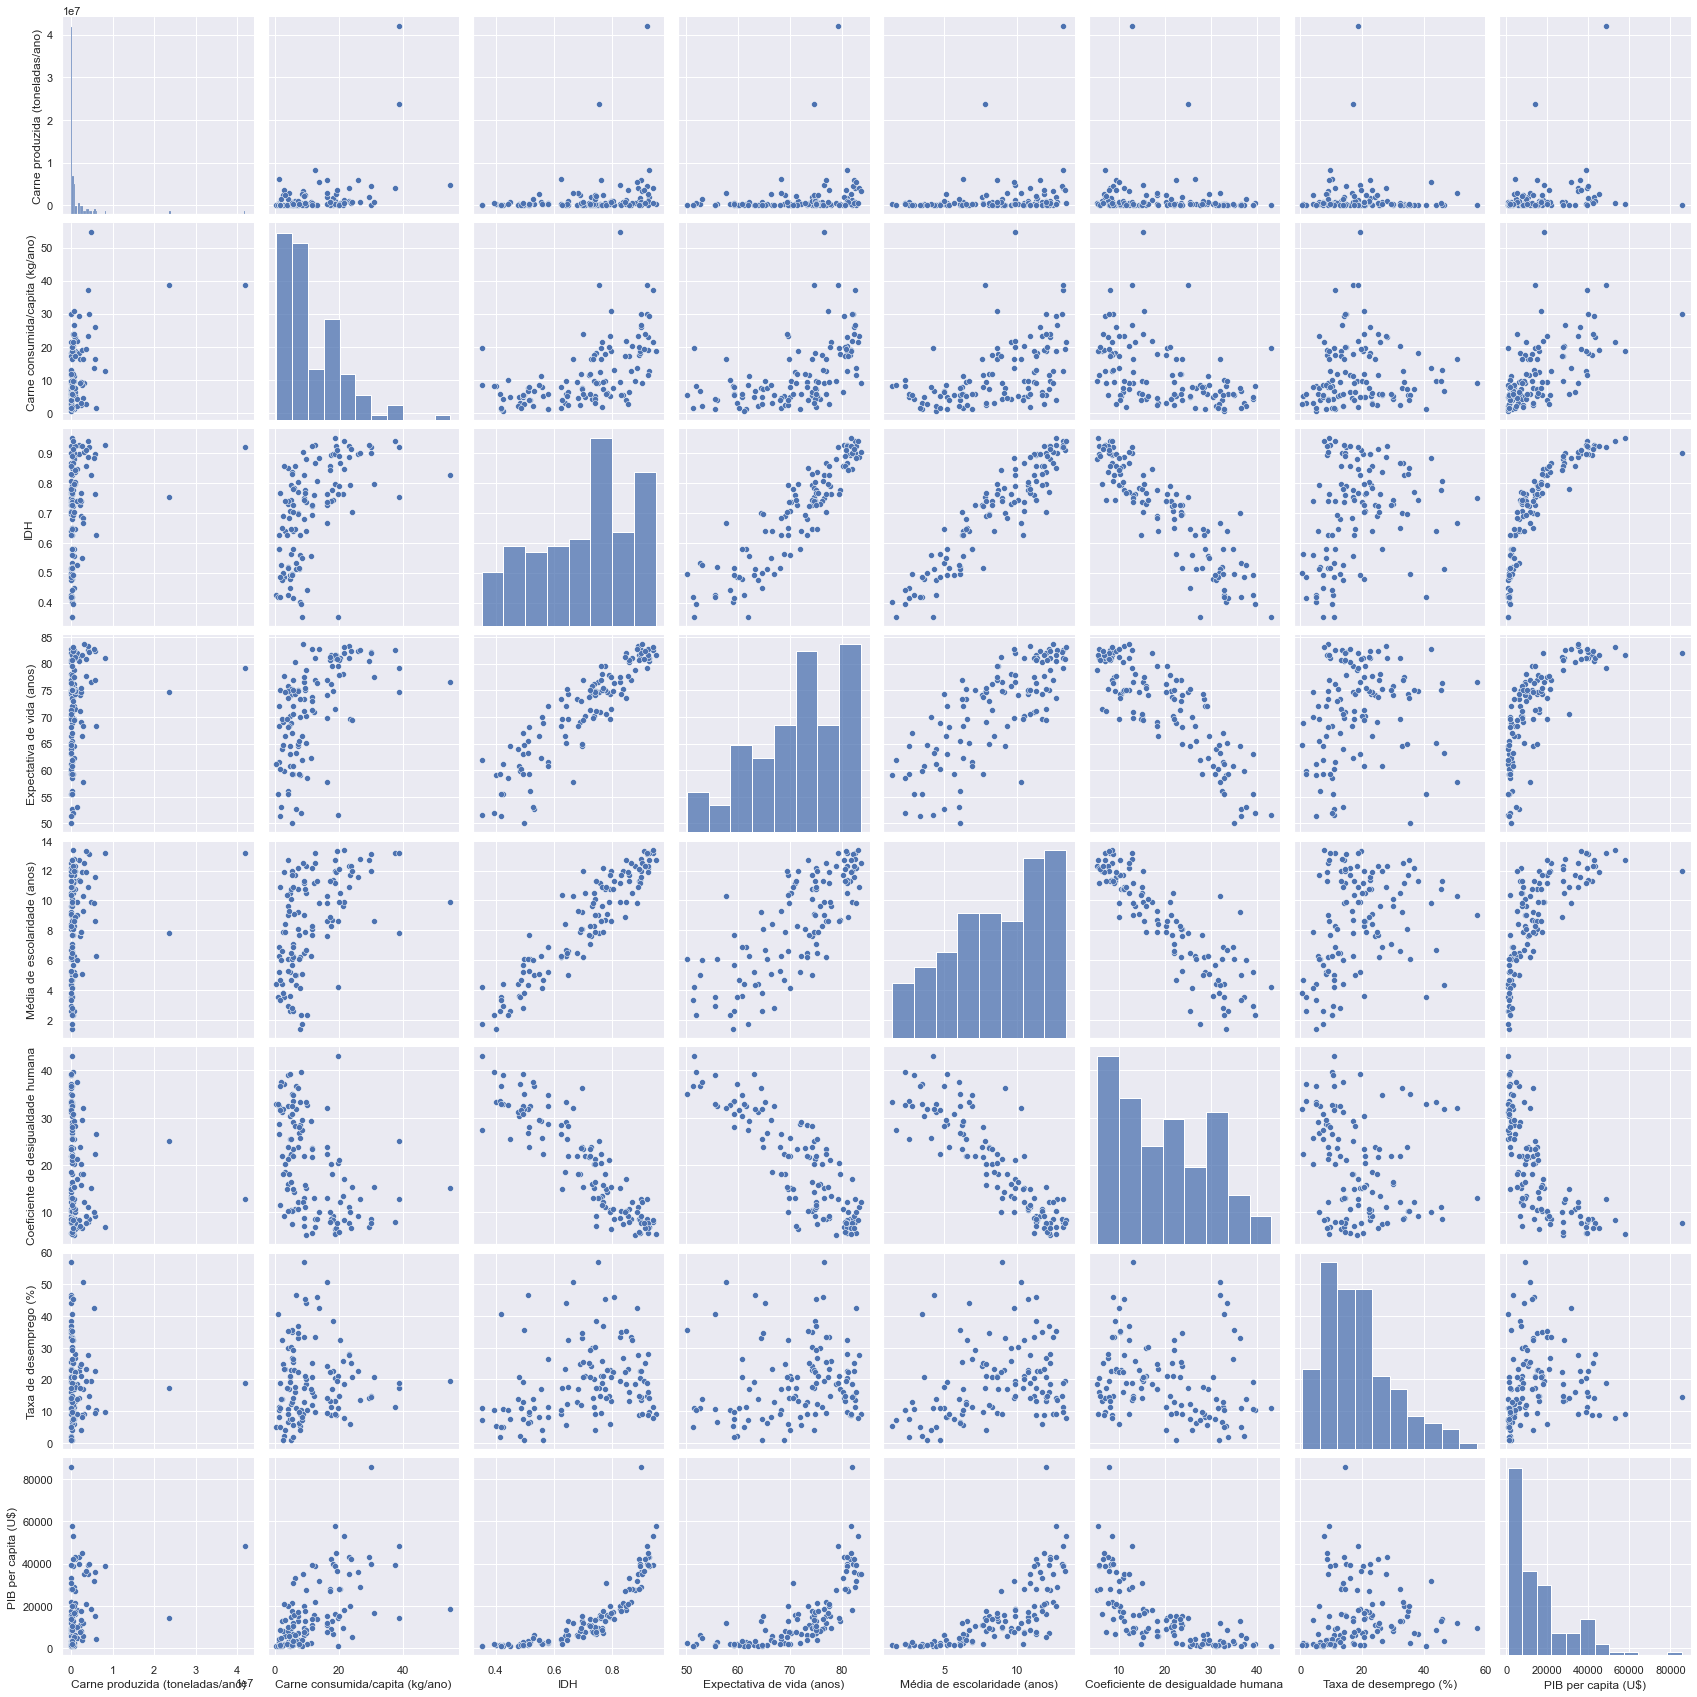

In [70]:
%matplotlib inline
import seaborn as sns
sns.pairplot(df, height=3);

<IPython.core.display.Javascript object>


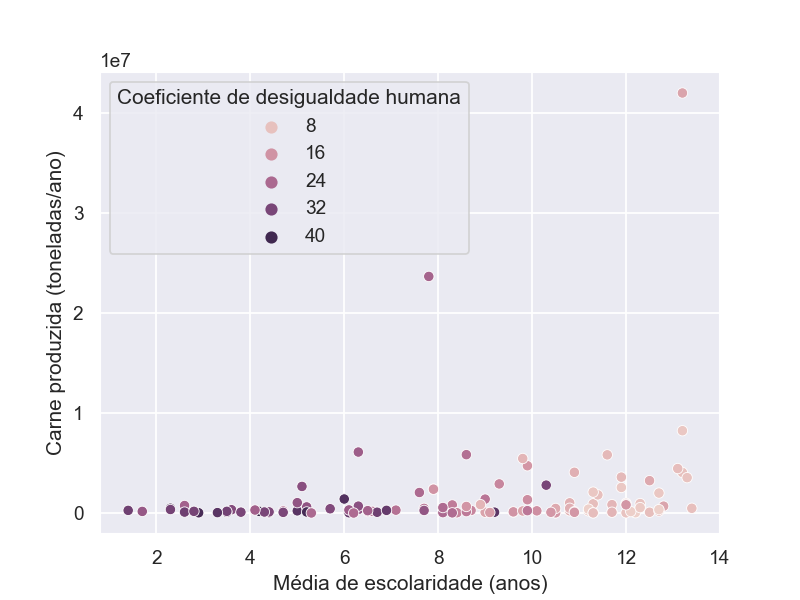

In [53]:
sns.set_theme(color_codes=True)
fig_esc = sns.scatterplot(data=df, x='Média de escolaridade (anos)', y='Carne produzida (toneladas/ano)', hue='Coeficiente de desigualdade humana')
plt.show(fig_esc)

#### Neste gráfico nota-se o alto grau de relação (inversamente proporcionais) entre a média de escolaridade e o coeficiente de desigualdade humana, tendo em vista que à medida que o eixo X (média de escolaridade) cresce, mais bolinhas brancas (menor coeficiente de desigualdade) são observadas. Apesar disso, é possivel observar que nenhuma das variáveis tem uma significante relação com a carne produzida. Isso, pois alguns pontos de escolaridade são observados num maior nível de carne produzida, porém essa diferença é muito inconstante e não é muito significativa. 

<IPython.core.display.Javascript object>


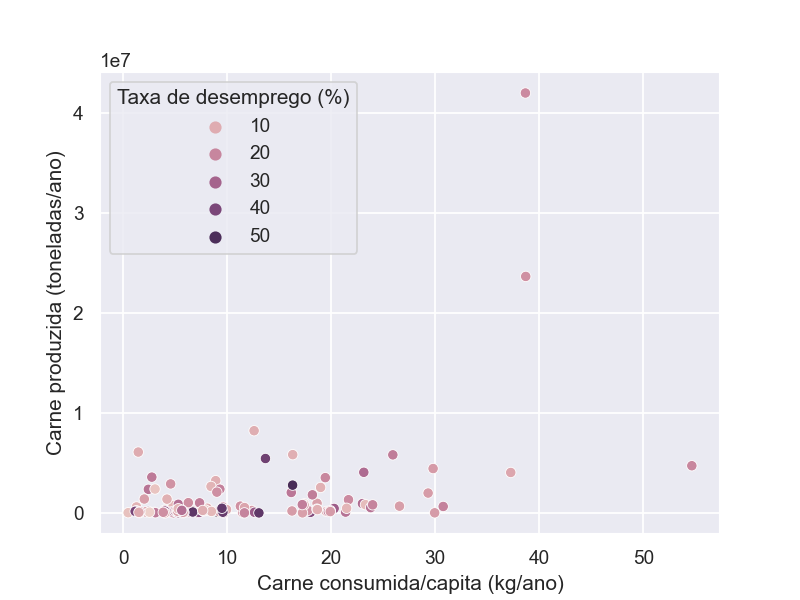

In [65]:
fig_consum = sns.scatterplot(data=df, x='Carne consumida/capita (kg/ano)', y='Carne produzida (toneladas/ano)', hue='Taxa de desemprego (%)')
plt.show(fig_consum)

#### Com o gráfico, nota-se que a taxa de desemprego não apresenta nenhum grau de relação aparente com a carne consumida, tendo em vista que a cor das bolinhas não apresenta nenhum padrão à medida que o eixo X (carne consumida) cresce. Apesar disso, é evidente que os países com maior carne produzida estão localizados à direita do gráfico (mostrando que os países com maior consumo de carne são os mesmos que apresentam maior produção dela.

## Regressões

In [54]:
#Criando uma função que sirva para criar as regressões que vamos utilizar para analisar o projeto
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [55]:
#Criando uma nova variável com o dataset final para facilitar
df = tabela_final[['Carne produzida (toneladas/ano)', 'Carne consumida/capita (kg/ano)',
       'IDH', 'Expectativa de vida (anos)', 'Média de escolaridade (anos)',
       'Coeficiente de desigualdade humana', 'Taxa de desemprego (%)',
       'PIB per capita (U$)']]

In [56]:
df.describe()

,Carne produzida (toneladas/ano),Carne consumida/capita (kg/ano),IDH,Expectativa de vida (anos),Média de escolaridade (anos),Coeficiente de desigualdade humana,Taxa de desemprego (%),PIB per capita (U$)
count,1.210000e+02,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,1.500236e+06,11.749174,0.705091,71.523967,8.559504,19.768595,18.919835,15462.403182
std,4.511072e+06,9.517539,0.162174,8.735770,3.253449,10.302096,11.503569,15349.107505
min,8.380000e+02,0.490000,0.352000,50.100000,1.400000,5.300000,0.700000,795.682826
25%,9.584700e+04,4.990000,0.563000,65.100000,6.100000,10.200000,10.300000,3269.794329
50%,2.858190e+05,8.490000,0.739000,74.200000,9.000000,18.200000,17.100000,10227.325960
75%,9.714000e+05,17.750000,0.843000,78.000000,11.300000,28.600000,25.000000,21048.330520
max,4.195275e+07,54.650000,0.949000,83.700000,13.400000,43.100000,57.200001,85613.586610


In [42]:
#Separando em 'target' e 'feature' para fazer a regressão
X1 = df[['Carne consumida/capita (kg/ano)',
       'IDH', 'Expectativa de vida (anos)', 'Média de escolaridade (anos)',
       'Coeficiente de desigualdade humana', 'Taxa de desemprego (%)',
       'PIB per capita (U$)']]
Y1 = df['Carne produzida (toneladas/ano)']

### Primeira regressão.

In [58]:
#Fazendo a regressão
results = regress(Y1,X1)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Carne produzida (toneladas/ano)   R-squared:                       0.221
Model:                                         OLS   Adj. R-squared:                  0.173
Method:                              Least Squares   F-statistic:                     4.584
Date:                             Tue, 30 Nov 2021   Prob (F-statistic):           0.000154
Time:                                     14:49:18   Log-Likelihood:                -2010.0
No. Observations:                              121   AIC:                             4036.
Df Residuals:                                  113   BIC:                             4058.
Df Model:                                        7                                         
Covariance Type:                         nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               -9.24e+06   8.48e+06     -1.089      0.278    -2.6e+07    7.57e+06
Carne consumida/capita (kg/ano)      1.95e+05   5.04e+04      3.872      0.000    9.52e+04    2.95e+05
IDH                                 8.821e+06   1.32e+07      0.668      0.506   -1.74e+07     3.5e+07
Expectativa de vida (anos)         -2.066e+04   1.39e+05     -0.148      0.882   -2.96e+05    2.55e+05
Média de escolaridade (anos)        7.769e+04   4.26e+05      0.182      0.856   -7.67e+05    9.22e+05
Coeficiente de desigualdade humana  1.659e+05   9.93e+04      1.671      0.097   -3.08e+04    3.63e+05
Taxa de desemprego (%)             -1.875e+04   3.66e+04     -0.512      0.610   -9.13e+04    5.38e+04
PIB per capita (U$)                    7.4968     46.782      0.160      0.873     -85.186     100.180
==============================================================================
Omnibus:                      178.950   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10400.199
Skew:                           5.680   Prob(JB):                         0.00
Kurtosis:                      46.975   Cond. No.                     7.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Segunda regressão - agora iremos retirar a expectativa de vida do dataset e refazer a regressão para analisar outra feature, que no caso será o PIB per capta (maior P>|t|).

In [44]:
#Separando em 'target' e 'feature' para fazer a regressão
X2 = df[['Carne consumida/capita (kg/ano)',
       'IDH','Média de escolaridade (anos)',
       'Coeficiente de desigualdade humana', 'Taxa de desemprego (%)',
       'PIB per capita (U$)']]
Y2 = df['Carne produzida (toneladas/ano)']

In [45]:
#Fazendo a regressão
results = regress(Y2,X2)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Carne produzida (toneladas/ano)   R-squared:                       0.221
Model:                                         OLS   Adj. R-squared:                  0.180
Method:                              Least Squares   F-statistic:                     5.391
Date:                             Tue, 30 Nov 2021   Prob (F-statistic):           6.19e-05
Time:                                     14:08:21   Log-Likelihood:                -2010.0
No. Observations:                              121   AIC:                             4034.
Df Residuals:                                  114   BIC:                             4054.
Df Model:                                        6                                         
Covariance Type:                         nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -1.016e+07   5.75e+06     -1.767      0.080   -2.16e+07    1.23e+06
Carne consumida/capita (kg/ano)     1.946e+05   5.01e+04      3.886      0.000    9.54e+04    2.94e+05
IDH                                  7.31e+06   8.38e+06      0.872      0.385    -9.3e+06    2.39e+07
Média de escolaridade (anos)        1.174e+05    3.3e+05      0.356      0.723   -5.37e+05    7.71e+05
Coeficiente de desigualdade humana  1.724e+05   8.87e+04      1.943      0.054   -3346.386    3.48e+05
Taxa de desemprego (%)             -1.762e+04   3.57e+04     -0.494      0.622   -8.83e+04     5.3e+04
PIB per capita (U$)                    9.1136     45.299      0.201      0.841     -80.624      98.851
==============================================================================
Omnibus:                      178.793   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10359.911
Skew:                           5.673   Prob(JB):                         0.00
Kurtosis:                      46.888   Cond. No.                     5.67e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Terceira regressão - agora iremos retirar o PIB per capita do dataset e refazer a regressão para analisar outra feature, que no caso será a média de escolaridade (maior P>|t|).

In [59]:
#Separando em 'target' e 'feature' para fazer a regressão
X3 = df[['Carne consumida/capita (kg/ano)',
       'IDH','Média de escolaridade (anos)',
       'Coeficiente de desigualdade humana', 'Taxa de desemprego (%)']]
Y3 = df['Carne produzida (toneladas/ano)']

In [60]:
#Fazendo a regressão
results = regress(Y3,X3)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Carne produzida (toneladas/ano)   R-squared:                       0.221
Model:                                         OLS   Adj. R-squared:                  0.187
Method:                              Least Squares   F-statistic:                     6.515
Date:                             Tue, 30 Nov 2021   Prob (F-statistic):           2.27e-05
Time:                                     14:49:58   Log-Likelihood:                -2010.1
No. Observations:                              121   AIC:                             4032.
Df Residuals:                                  115   BIC:                             4049.
Df Model:                                        5                                         
Covariance Type:                         nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -1.052e+07   5.45e+06     -1.929      0.056   -2.13e+07     2.8e+05
Carne consumida/capita (kg/ano)      1.97e+05   4.85e+04      4.065      0.000    1.01e+05    2.93e+05
IDH                                 8.065e+06   7.47e+06      1.080      0.282   -6.72e+06    2.29e+07
Média de escolaridade (anos)        1.131e+05   3.28e+05      0.345      0.731   -5.37e+05    7.63e+05
Coeficiente de desigualdade humana  1.728e+05   8.84e+04      1.955      0.053   -2268.768    3.48e+05
Taxa de desemprego (%)             -1.944e+04   3.44e+04     -0.566      0.573   -8.75e+04    4.86e+04
==============================================================================
Omnibus:                      179.465   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10548.064
Skew:                           5.704   Prob(JB):                         0.00
Kurtosis:                      47.295   Cond. No.                         756.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Quarta regressão - agora iremos retirar a média de escolaridade (maior P>|t|).

In [48]:
#Separando em 'target' e 'feature' para fazer a regressão
X4 = df[['Carne consumida/capita (kg/ano)',
       'IDH','Coeficiente de desigualdade humana', 'Taxa de desemprego (%)']]
Y4 = df['Carne produzida (toneladas/ano)']

In [49]:
#Fazendo a regressão
results = regress(Y4,X4)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Carne produzida (toneladas/ano)   R-squared:                       0.220
Model:                                         OLS   Adj. R-squared:                  0.193
Method:                              Least Squares   F-statistic:                     8.177
Date:                             Tue, 30 Nov 2021   Prob (F-statistic):           7.62e-06
Time:                                     14:08:32   Log-Likelihood:                -2010.1
No. Observations:                              121   AIC:                             4030.
Df Residuals:                                  116   BIC:                             4044.
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -1.052e+07   5.43e+06     -1.937      0.055   -2.13e+07    2.39e+05
Carne consumida/capita (kg/ano)     1.966e+05   4.83e+04      4.075      0.000    1.01e+05    2.92e+05
IDH                                 9.642e+06   5.88e+06      1.639      0.104   -2.01e+06    2.13e+07
Coeficiente de desigualdade humana  1.639e+05   8.42e+04      1.946      0.054   -2893.022    3.31e+05
Taxa de desemprego (%)             -1.755e+04   3.38e+04     -0.519      0.604   -8.45e+04    4.94e+04
==============================================================================
Omnibus:                      180.386   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10811.562
Skew:                           5.748   Prob(JB):                         0.00
Kurtosis:                      47.859   Cond. No.                         667.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:

# load and summarize the housing dataset
from pandas import read_csv
# load dataset
# summarize shape
print(df.shape)
...
# split into inputs and outputs
X, y = df[:, :-1], df[:, -1]
print(X.shape, y.shape)

(121, 8)


TypeError: '(slice(None, None, None), slice(None, -1, None))' is an invalid key

In [85]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(df, df['Carne produzida (toneladas/ano)'])
df.reshape(1, -1)
y_pred = regressor.predict(df['Carne produzida (toneladas/ano)'])




AttributeError: 'DataFrame' object has no attribute 'reshape'